In [1]:
import pandas as pd
from ggplot import *

project_id = "the-d-team-164512"

In [5]:
query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.brandName = 'LIPITOR'
GROUP BY
  brand_name
  , date
ORDER BY
  brand_name
  , date ASC
"""

df_lipitor = pd.read_gbq(query, project_id)
df_lipitor.head(3)

Waiting for job to complete...


,brand_name,date,transaction_count
0,LIPITOR,2010-12-26,102
1,LIPITOR,2011-01-02,8489
2,LIPITOR,2011-01-09,10478


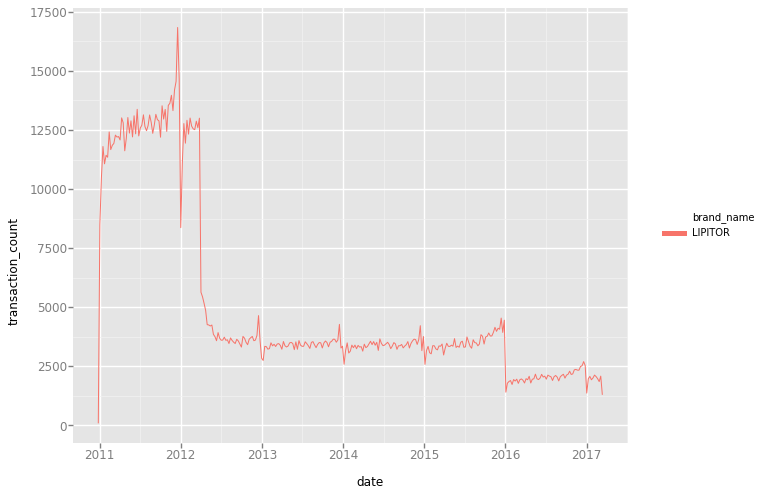

<ggplot: (277883126)>

In [6]:
df_lipitor.date = pd.Series(df_lipitor.date).apply(pd.to_datetime, format='%Y-%m-%d')
ggplot(
    aes(x='date', y='transaction_count', colour='brand_name'),
    data=df_lipitor) +\
    geom_line()

In [7]:
query = """\
SELECT
  d.ATCLevel5Code
  , d.BrandName AS brand_name
  , (CASE WHEN d.BrandName = 'LIPITOR' THEN 'LIPITOR' ELSE 'NON LIPITOR' END) AS lipitor
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.ATCLevel5Code = 'C10AA05'
GROUP BY
  d.ATCLevel5Code
  , brand_name
  , lipitor
  , date
ORDER BY
  d.ATCLevel5Code
  , brand_name
  , date ASC
"""
df_rpl = pd.read_gbq(query, project_id)
df_rpl.head(3)

Waiting for job to complete...


,d_ATCLevel5Code,brand_name,lipitor,date,transaction_count
0,C10AA05,ATORVACHOL,NON LIPITOR,2012-05-27,24
1,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-03,111
2,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-10,128


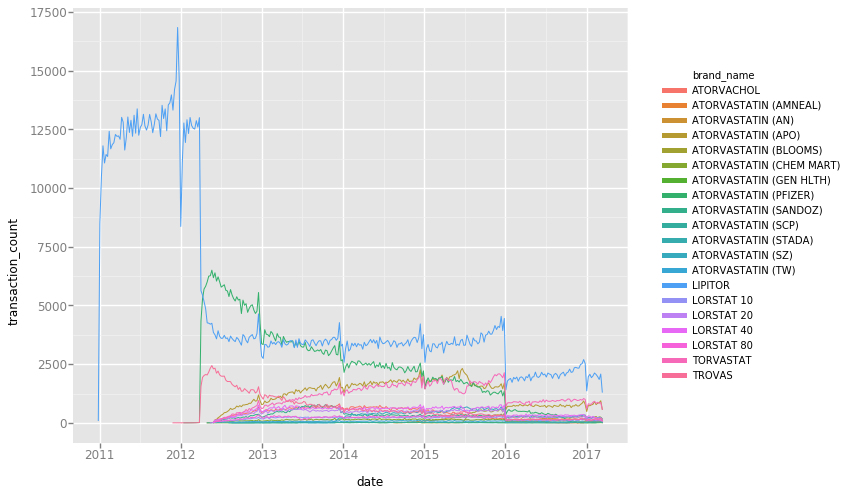

<ggplot: (278190554)>

In [8]:
df_rpl.date = pd.Series(df_rpl.date).apply(pd.to_datetime, format='%Y-%m-%d')
ggplot(
    aes(x='date', y='transaction_count', colour='brand_name'),
    data=df_rpl) +\
    geom_line()

## Lipitor out of patent Nov 2011
As Lipitor goes [out of patent](https://en.wikipedia.org/wiki/Atorvastatin) it is replaced by other statins predominangly versions of atorvastatin.

* who is the first to pick this up? by store? by geography?
* what is the cost impact?
* surprisingly there is no increase in useage?

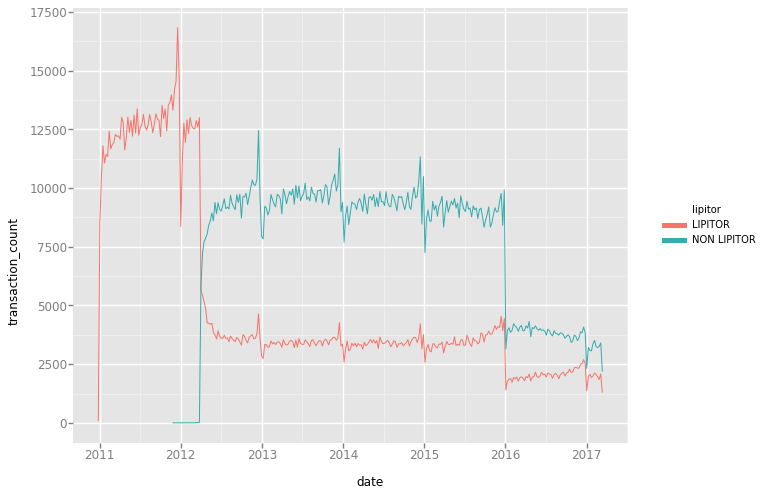

<ggplot: (-9223372036577015548)>

In [9]:
df_lip = df_rpl.groupby(['date', 'lipitor']).sum()    
df_lip.reset_index(inplace=True)
df_lip
ggplot(
    aes(x='date', y='transaction_count', colour='lipitor'),
    data=df_lip) +\
    geom_line()

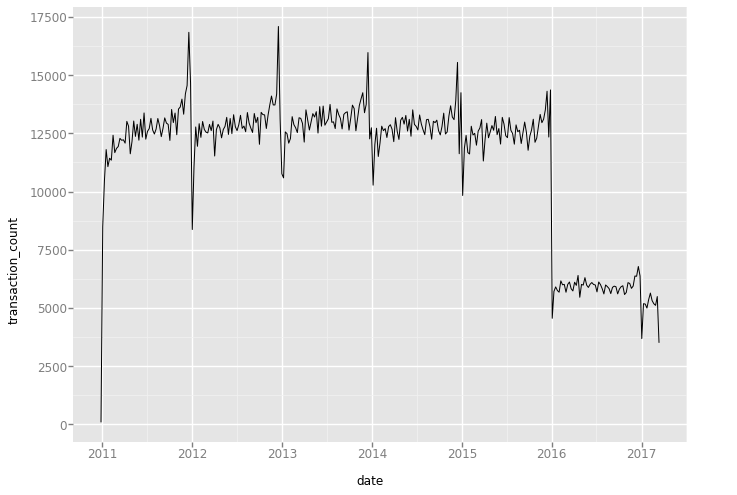

<ggplot: (277995128)>

In [11]:
df_lip_all = df_rpl.groupby(['date']).sum()    
df_lip_all.reset_index(inplace=True)
ggplot(
    aes(x='date', y='transaction_count'),
    data=df_lip_all) +\
    geom_line(position = 'stack')

In [15]:
query = """\
SELECT
  pc.state AS state
  , d.ATCLevel5Code
  , d.BrandName AS brand_name
  , (CASE WHEN d.BrandName = 'LIPITOR' THEN 'LIPITOR' ELSE 'NON LIPITOR' END) AS lipitor
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
  , SUM(pcd.distance) AS cumulative_store_distance
  , NTH(4, QUANTILES(pcd.distance, 5)) AS seventy_fifth
  , SUM(t.PatientPrice_Amt) AS cumulative_patient_price
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
JOIN dthon.patients_lookup p
ON t.patient_id = p.patient_id
JOIN dthon.stores_lookup s
ON s.store_id = t.store_id
JOIN dthon.postcodes pc
ON p.postcode = pc.postcode
JOIN dthon.postcode_distances pcd
ON p.postcode = pcd.from_postcode AND s.postcode = pcd.to_postcode
WHERE d.ATCLevel5Code = 'C10AA05'
GROUP BY
  state
  , d.ATCLevel5Code
  , brand_name
  , lipitor
  , date
ORDER BY
  state
  , d.ATCLevel5Code
  , brand_name
  , date ASC
"""

df_dist_price = pd.read_gbq(query, project_id)
df_dist_price.head(3)

Waiting for job to complete...
Waiting for job to complete...
Waiting for job to complete...
Waiting for job to complete...


,state,d_ATCLevel5Code,brand_name,lipitor,date,transaction_count,cumulative_store_distance,seventy_fifth,cumulative_patient_price
0,ACT,C10AA05,ATORVACHOL,NON LIPITOR,2012-09-09,5,484.860951,96.972190,177
1,ACT,C10AA05,ATORVACHOL,NON LIPITOR,2012-11-11,4,2174.616031,821.320177,0
2,ACT,C10AA05,ATORVACHOL,NON LIPITOR,2012-12-09,2,1642.640354,821.320177,0


In [16]:
df_dist_price.date = pd.Series(df_dist_price.date).apply(pd.to_datetime, format='%Y-%m-%d')

**There must be something wrong in my query?**
* Why is the price of non-lipitor so much higher then lipitor?
* why does the non-lipitor price vary so much?

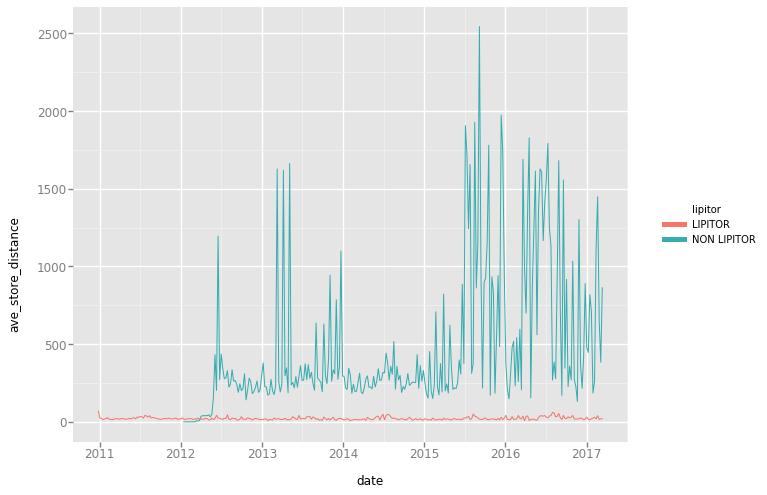

<ggplot: (-9223372036576646449)>

In [17]:
df_dist_price['ave_store_distance'] = df_dist_price.cumulative_store_distance / df_dist_price.transaction_count
df_dist_price['ave_patient_price'] = df_dist_price.cumulative_patient_price / df_dist_price.transaction_count
df_dist_price[df_dist_price['state'] == 'NSW']
df_l_d_p = df_dist_price[df_dist_price['state'] == 'VIC'].groupby(['date', 'lipitor']).sum()    
df_l_d_p.reset_index(inplace=True)
df_l_d_p
ggplot(
    aes(x='date', y='ave_store_distance', colour='lipitor'),
    data=df_l_d_p) +\
    geom_line()

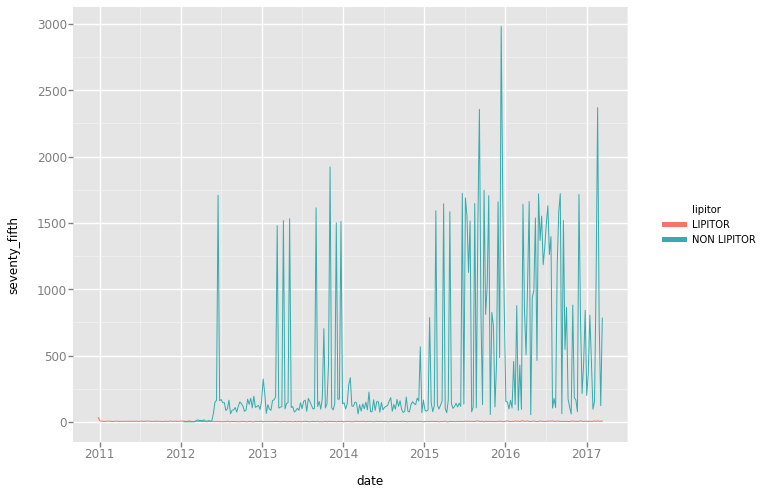

<ggplot: (277762866)>

In [18]:
ggplot(
    aes(x='date', y='seventy_fifth', colour='lipitor'),
    data=df_l_d_p) +\
    geom_line()

**There has to be something wrong in my query?**
* why would the distance for non lipitor jump so high?
* are they being ordered from further away?
* or is there a miscalculation?

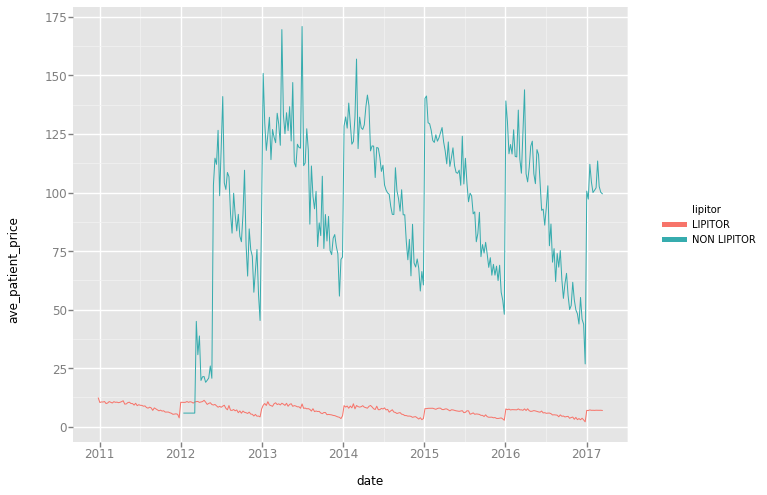

<ggplot: (281714759)>

In [20]:
ggplot(
    aes(x='date', y='ave_patient_price', colour='lipitor'),
    data=df_l_d_p) +\
    geom_line()

In [23]:
query = """\
SELECT
  d.ATCLevel5Code
  , a.ATCLevel5Name
  , DATE(t.Dispense_Week) AS date
  , SUM(pcd.distance) AS sum_distance
  , SUM(t.PatientPrice_Amt) AS sum_price
  , NTH(4, QUANTILES(pcd.distance, 5)) AS seventy_fifth
  , count(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
JOIN dthon.patients_lookup p
ON t.patient_id = p.patient_id
JOIN dthon.stores_lookup s
ON s.store_id = t.store_id
JOIN dthon.postcode_distances pcd
ON p.postcode = pcd.from_postcode AND s.postcode = pcd.to_postcode
JOIN dthon.atc_lookup a
ON a.ATCLevel5Code = d.ATCLevel5Code
WHERE
  d.ATCLevel5Code IN ('C10AA07', 'N02BE01', 'C10AA05', 'A02BC05', 'C09AA04', 'C09CA07', 'R03BB04', 'C07AB03', 'C09CA06', 'A02BC02')
GROUP BY
  d.ATCLevel5Code
  , a.ATCLevel5Name
  , date
ORDER BY
  d.ATCLevel5Code
  , date ASC
"""

df_pop = pd.read_gbq(query, project_id)
df_pop.date = pd.Series(df_pop.date).apply(pd.to_datetime, format='%Y-%m-%d')
df_pop.head(3)

Waiting for job to complete...
Waiting for job to complete...
Waiting for job to complete...


,d_ATCLevel5Code,a_ATCLevel5Name,date,sum_distance,sum_price,seventy_fifth,transaction_count
0,A02BC02,PANTOPRAZOLE,2010-12-26,1951.415201,431.13,4.438794,37
1,A02BC02,PANTOPRAZOLE,2011-01-02,107448.072460,29395.63,3.195627,3093
2,A02BC02,PANTOPRAZOLE,2011-01-09,121727.620578,36674.29,3.360555,3875


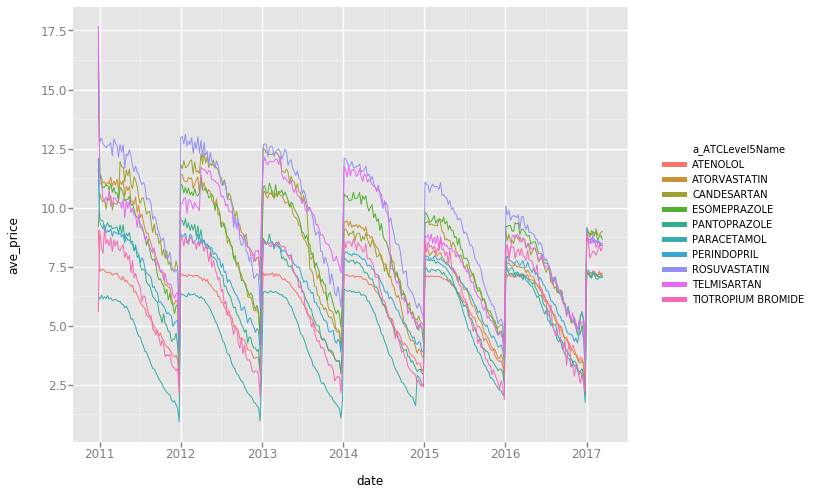

<ggplot: (282428701)>

In [24]:
df_pop['ave_distance'] = df_pop.sum_distance / df_pop.transaction_count
df_pop['ave_price'] = df_pop.sum_price / df_pop.transaction_count
ggplot(
    aes(x='date', y='ave_price', colour='a_ATCLevel5Name'),
    data=df_pop) +\
    geom_line()

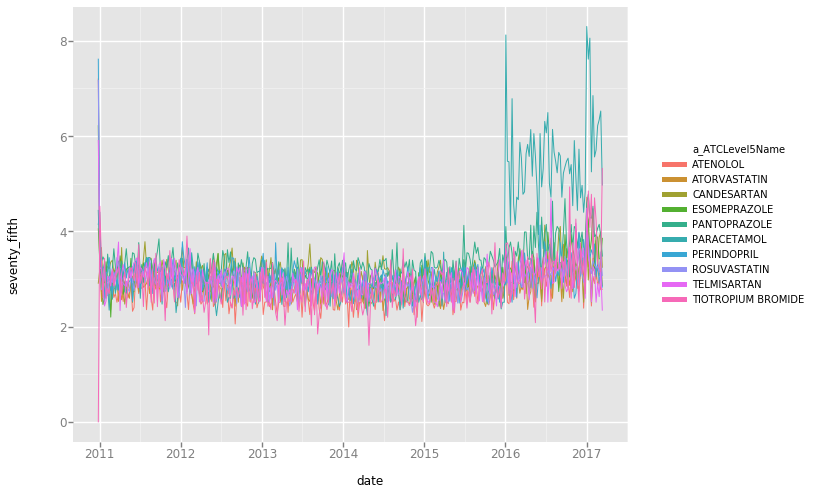

<ggplot: (281650934)>

In [26]:
ggplot(
    aes(x='date', y='seventy_fifth', colour='a_ATCLevel5Name'),
    data=df_pop) +\
    geom_line() +\
    stat_smooth(aes(y = t1_all_estimate, group=1, colour="Obese"     ), method=lm, formula = y ~ poly(x,2), level=0.95) + #tweak the signifance level suitable for your study
